->>>> th: dtw gerarchico  > euclidean kmeans

clustering: 
1. calcolo distanze -> output: matrice distance 
2. capisco qti cluster 
3. matrice -> clustering 

4. visualizzo, ottengo statistiche, blablabla 
4,5. scelgo rappresentanti 
5. weight optimization <- ottimizzazione lineare 
6. arima e backtesting

In [2]:
# Load the cleaned S&P 500 DataFrame from a pickle file
import pandas as pd
import pickle
with open('data\pickle_files\cleaned_sp500_daily.pkl', 'rb') as file:
    df_sp500 = pickle.load(file)
    
# Fill any missing values by forward-filling and then backward-filling
df_sp500.fillna(method='ffill', inplace=True)  # Forward-fill for existing gaps
df_sp500.fillna(method='bfill', inplace=True)  # Backward-fill for leading gaps


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\giuli\AppData\Local\Temp\ipykernel_2204\2170963958.py:4: SyntaxWarning: invalid escape sequence '\p'
  with open('data\pickle_files\cleaned_sp500_daily.pkl', 'rb') as file:
C:\Users\giuli\AppData\Local\Temp\ipykernel_2204\2170963958.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sp500.fillna(method='ffill', inplace=True)  # Forward-fill for existing gaps
C:\Users\giuli\AppData\Local\Temp\ipykernel_2204\2170963958.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sp500.fillna(method='bfill', inplace=True)  # Backward-fill for leading gaps


In [3]:
# Assuming df_sp500 contains stock prices with Date as index and tickers as columns
df = df_sp500.copy()

In [4]:
df.info

<bound method DataFrame.info of Ticker                           TSLA         MLM        POOL        PAYX  \
Date                                                                        
2014-10-14 00:00:00+00:00   15.137333   98.845337   47.631180   31.855057   
2014-10-15 00:00:00+00:00   15.313333  100.631470   47.970528   31.496561   
2014-10-16 00:00:00+00:00   15.090000  104.286591   51.328083   31.525818   
2014-10-17 00:00:00+00:00   15.165333  108.374489   50.801243   31.825790   
2014-10-20 00:00:00+00:00   15.364667  110.114586   51.337040   32.008709   
...                               ...         ...         ...         ...   
2024-10-07 00:00:00+00:00  240.830002  518.650024  363.019989  136.533539   
2024-10-08 00:00:00+00:00  244.500000  523.989990  364.940002  137.248795   
2024-10-09 00:00:00+00:00  241.050003  531.159973  365.739990  138.917709   
2024-10-10 00:00:00+00:00  238.770004  534.520020  362.500000  138.371338   
2024-10-11 00:00:00+00:00  217.800003  544.9

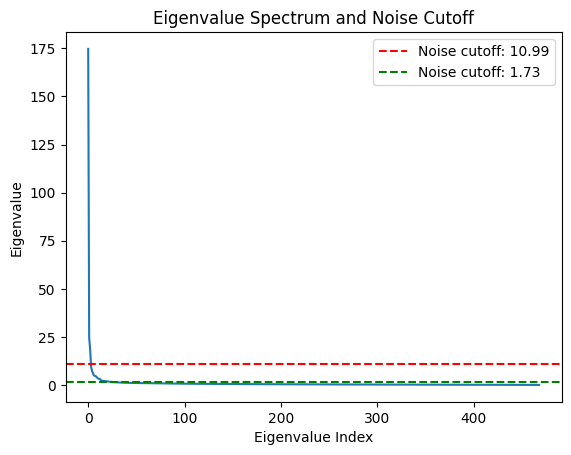

NaNs in df_final: 0
Final DataFrame shape: (2515, 469)


C:\Users\giuli\AppData\Local\Temp\ipykernel_2204\1593125750.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


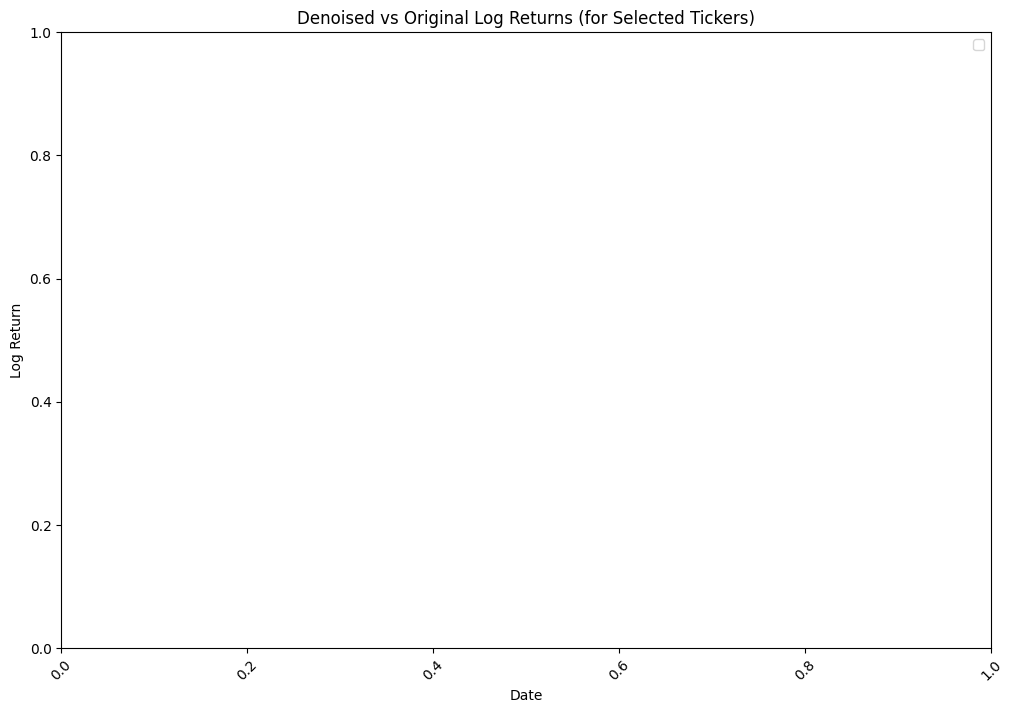

In [10]:

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Calculate daily log returns
df_log_returns = np.log(df / df.shift(1)).dropna()

# Step 2: Standardize the returns (important for PCA)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_log_returns), columns=df_log_returns.columns, index=df_log_returns.index)

# Step 3: Perform PCA directly on standardized log-returns
pca = PCA()
pca.fit(df_scaled)  # Apply PCA on standardized returns

# Step 4: Get eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# Step 5: Apply Marcenko-Pastur Law to find noise cutoff
n, p = df_scaled.shape  # n: number of days, p: number of assets
gamma = n / p  # Ratio from Marcenko-Pastur law

lambda_plus = (1 + np.sqrt(gamma))**2
lambda_minus = (1 - np.sqrt(gamma))**2

# Plot the eigenvalues to visualize the signal/noise
plt.plot(np.sort(eigenvalues)[::-1])
plt.axhline(lambda_plus, color='r', linestyle='--', label=f'Noise cutoff: {lambda_plus:.2f}')
plt.axhline(lambda_minus, color='g', linestyle='--', label=f'Noise cutoff: {lambda_minus:.2f}')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Eigenvalue Spectrum and Noise Cutoff')
plt.show()

# Step 6: Denoising
# Identify signal eigenvectors (those above lambda_plus)
signal_eigenvectors = eigenvectors[eigenvalues > lambda_plus]

# Reconstruct the denoised data (using only the signal eigenvectors)
df_denoised = np.dot(signal_eigenvectors.T, np.dot(signal_eigenvectors, df_scaled.T)).T

# Step 7: Remove market effect (first PC)
first_pc = eigenvectors[0].reshape(-1, 1)  # First principal component
market_component = df_scaled @ first_pc @ first_pc.T  # Projection onto market factor

# Remove the market effect from the denoised data
df_final = df_denoised - market_component

# Check for NaNs in the final data
print(f"NaNs in df_final: {df_final.isna().sum().sum()}")  # Total number of NaNs

# Ensure the result is aligned and doesn't have NaNs
print("Final DataFrame shape:", df_final.shape)

# Optional: Plot the denoised and original log returns for a few tickers (if no NaNs)
tickers_to_plot = ['1']
plt.figure(figsize=(12,8))
for ticker in tickers_to_plot:
    if ticker in df_scaled.columns:
        plt.plot(df_scaled[ticker], label=f'{ticker} (Original)', alpha=0.6)
        plt.plot(df_final[ticker], label=f'{ticker} (Denoised)', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.title('Denoised vs Original Log Returns (for Selected Tickers)')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Ensure that df_final has the same column names as the original df
df_final = pd.DataFrame(df_denoised - market_component, columns=df_scaled.columns, index=df_scaled.index)


In [13]:
df_final

Ticker,TSLA,MLM,POOL,PAYX,JCI,GPC,CAH,AJG,DLTR,HOLX,...,RCL,PRU,GRMN,HAS,ESS,NUE,JBHT,AMAT,ACGL,PYPL
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-16 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-21 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-08 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-09 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on each column in the returns DataFrame
adf_results = {}
for column in returns.columns:
    result = adfuller(returns[column], autolag='AIC')
    adf_results[column] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4],
        'Stationary': result[1] < 0.05  # True if p-value < 0.05
    }

# Display the results for the first few tickers
for ticker, result in list(adf_results.items())[:5]:  # Adjust the slice as needed
    print(f"Ticker: {ticker}")
    print(f"ADF Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    print(f"Critical Values: {result['Critical Values']}")
    print(f"Stationary: {result['Stationary']}")
    print("-" * 50)

NameError: name 'returns' is not defined

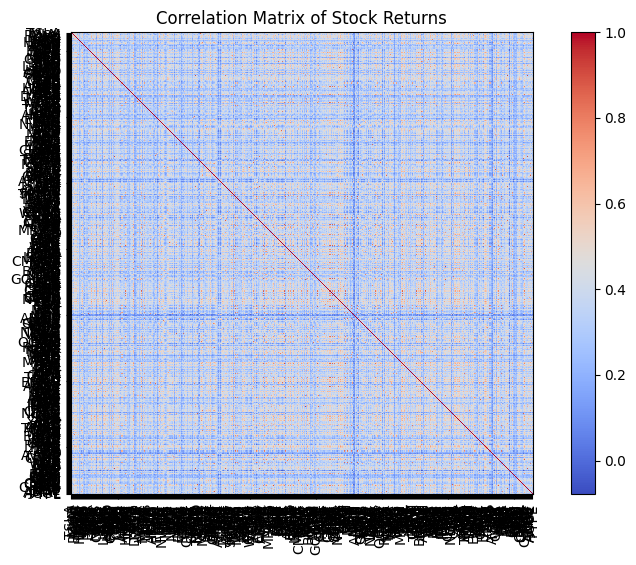

Most representative stocks of the index based on PCA:
Ticker
AMP      0.063595
BRK-B    0.062446
BLK      0.061558
HON      0.061539
AME      0.061512
dtype: float64


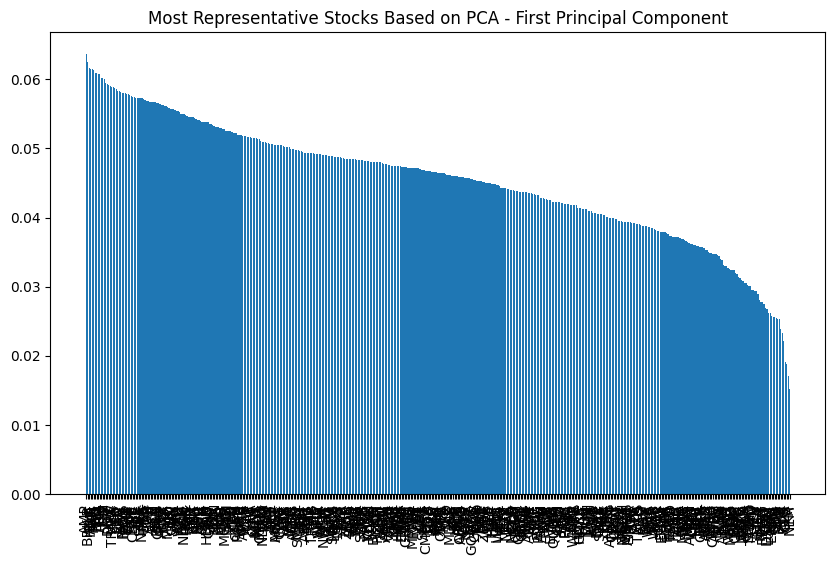

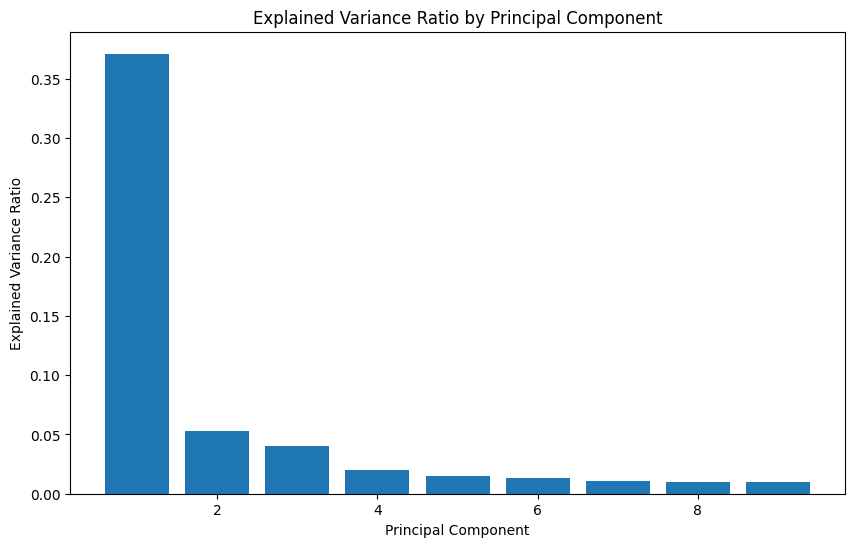

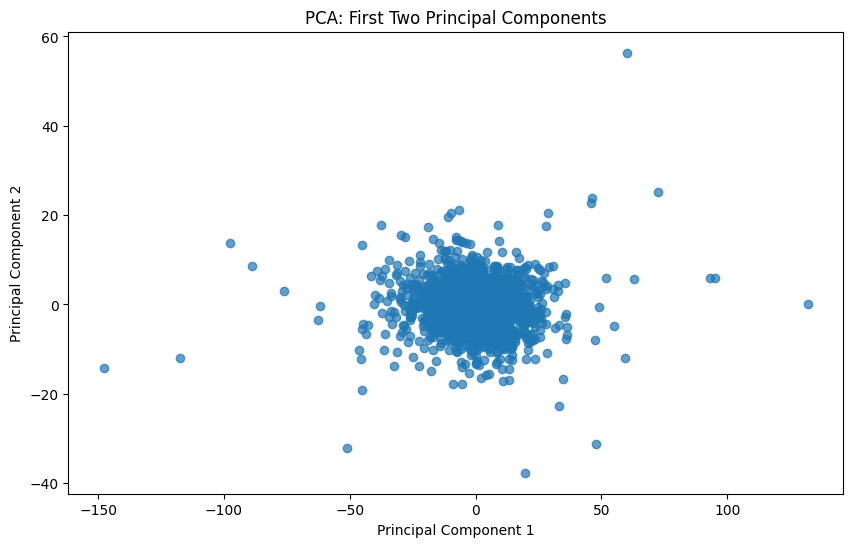

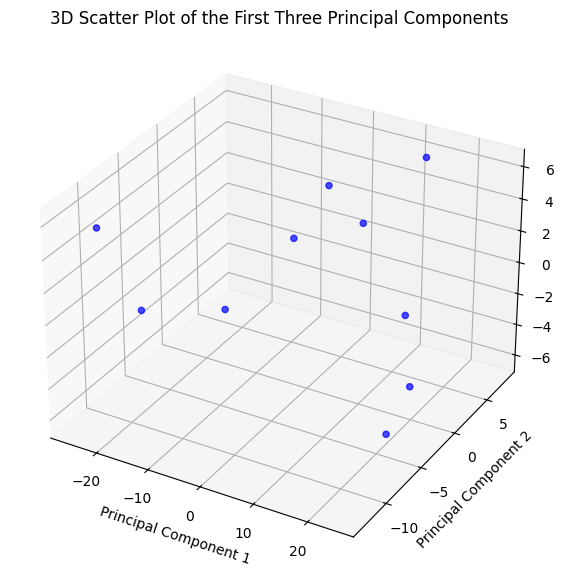

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as pdr

# Assuming df contains price data (rows are time, columns are tickers)
# Compute daily returns (percentage change) for each stock
returns = df.pct_change().dropna()

# Standardize the returns (important for PCA)
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

# Visualize the data before PCA (using the correlation matrix)
plt.figure(figsize=(10, 6))
plt.title('Correlation Matrix of Stock Returns')
plt.imshow(returns.corr(), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(returns.columns)), returns.columns, rotation=90)
plt.yticks(range(len(returns.columns)), returns.columns)
plt.show()

# Perform PCA to find the most representative stocks of the index
pca = PCA(n_components=9)  # Adjust n_components as needed
pca.fit(returns_scaled)

# Get the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Get the loadings (how each stock contributes to each component)
loadings = pca.components_

# Sort the loadings to find the stocks most contributing to the first principal component
pc1_loadings = loadings[0]  # Loadings for the first principal component
sorted_loadings = pd.Series(pc1_loadings, index=returns.columns).sort_values(ascending=False)

# Show the most representative stocks based on the first principal component
print("Most representative stocks of the index based on PCA:")
print(sorted_loadings.head())

# Plot the first principal component to visualize the most representative stocks
plt.figure(figsize=(10, 6))
plt.bar(sorted_loadings.index, sorted_loadings.values)
plt.title('Most Representative Stocks Based on PCA - First Principal Component')
plt.xticks(rotation=90)
plt.show()

# Visualize the variance explained by each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Plot the first two principal components
pca_2d = pca.transform(returns_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], alpha=0.7)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the first three principal components
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='b', marker='o', alpha=0.7)

# Label the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a title
ax.set_title('3D Scatter Plot of the First Three Principal Components')

# Show the plot
plt.show()



https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data

### Noise Filtering in Eigenvalue Spectra for Enhanced Clustering  

In quantitative finance, a significant challenge lies in distinguishing informative signals from noise in the eigenvalue spectrum of the covariance (or correlation) matrix of asset returns. This distinction is particularly crucial for improving Markowitz portfolio optimization, as an optimal portfolio should ideally lie on the efficient frontier with assets that exhibit minimal correlation. A well-established approach for identifying the noise cutoff in eigenvalues leverages the Marčenko-Pastur law, which describes the limiting spectral density of large random covariance matrices. The key parameter in this framework is the ratio \(\gamma = t/n\), where \(t\) represents the number of observations and \(n\) the number of assets, which governs the eigenvalue distribution. The noise threshold, denoted as \(\lambda_+\), serves as a boundary: eigenvalues above \(\lambda_+\) contain meaningful information, whereas those below it predominantly reflect noise.  

To remove noise-driven components from the dataset, a common technique involves projecting the original asset returns onto the principal component (PC) scores associated with the noise eigenvectors, yielding a regression model of the form \(Y = F_n \beta\). The residuals from this regression, \(X^* = Y - \hat{Y}\), constitute the denoised dataset, which can then be used for improved financial modeling and portfolio construction. Empirical studies have shown that portfolios formed using weights derived from the residual dataset exhibit significantly higher cumulative returns compared to those constructed without noise filtering.  

Furthermore, a fundamental method for isolating idiosyncratic asset behavior from market-wide effects involves removing the influence of the first principal component, which typically corresponds to the largest eigenvalue and represents the dominant market mode. This is accomplished by regressing asset returns on the first PC, \(Y = f_1 \beta\), and using the residuals as the adjusted dataset. By eliminating the common market factor, this technique mitigates the effects of market-wide correlation driven by herd behavior and sentiment-driven trading.  

### Relevance to Clustering in the S&P 500  

Incorporating this noise-filtering methodology into our dataset is crucial for improving the robustness of clustering analyses applied to the S&P 500. Clustering methods, particularly those based on time series similarity, are highly sensitive to the structure of the input data. If the dataset contains a high level of noise or is dominated by systemic market effects, the clustering results may be distorted, leading to misleading groupings of stocks.  

By removing the noise-driven eigenvalues and filtering out the dominant market component, we obtain a dataset that better captures the true underlying relationships between assets. This refined dataset allows for a more precise clustering of stocks based on their intrinsic return patterns rather than spurious correlations introduced by noise or broad market trends. In turn, this enhances the interpretability of the clusters, making them more meaningful for portfolio diversification, risk management, and trading strategies.  

Moreover, the denoised dataset helps in distinguishing structural similarities among stocks that persist over time, as opposed to transient correlations that arise due to macroeconomic shocks or market-wide sentiment shifts. This is particularly beneficial when applying distance-based clustering methods, such as k-means or dynamic time warping, where noisy correlations can obscure the true structure of the data.  

By integrating these denoising techniques into our clustering framework, we ensure that the identified clusters provide actionable insights into asset relationships, contributing to more effective financial decision-making.  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Calculate daily log returns
df_log_returns = np.log(df / df.shift(1)).dropna()

# Step 2: Standardize the returns (important for PCA)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_log_returns), columns=df_log_returns.columns, index=df_log_returns.index)

# Step 3: Perform PCA directly on standardized log-returns
pca = PCA()
pca.fit(df_scaled)  # Fix: Apply PCA on standardized returns

# Step 4: Get eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# Step 5: Apply Marcenko-Pastur Law to find noise cutoff
n, p = df_scaled.shape  # n: number of days, p: number of assets
gamma = n / p  # Ratio from Marcenko-Pastur law

lambda_plus = (1 + np.sqrt(gamma))**2
lambda_minus = (1 - np.sqrt(gamma))**2

# Plot the eigenvalues to visualize the signal/noise
plt.plot(np.sort(eigenvalues)[::-1])
plt.axhline(lambda_plus, color='r', linestyle='--', label=f'Noise cutoff: {lambda_plus:.2f}')
plt.axhline(lambda_minus, color='g', linestyle='--', label=f'Noise cutoff: {lambda_minus:.2f}')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Eigenvalue Spectrum and Noise Cutoff')
plt.show()

# Step 6: Denoising
# Get indices of noise eigenvalues
noise_indices = np.where(eigenvalues < lambda_plus)[0]
noise_eigenvectors = eigenvectors[noise_indices, :]

# Project onto noise eigenvectors
noise_projection = (noise_eigenvectors.T @ noise_eigenvectors) @ df_scaled.T  # Fix: Correct order of multiplication
df_denoised = df_scaled.T - noise_projection
df_denoised = df_denoised.T  # Transpose back to original shape

# Step 7: Remove market effect (first PC)
first_pc = eigenvectors[0].reshape(1, -1)  # First principal component
market_component = df_scaled @ first_pc.T @ first_pc  # Projection onto market factor

# Remove market effect
df_final = df_denoised - market_component  # Apply to denoised data

# Convert back to DataFrame
df_final = pd.DataFrame(df_final, columns=df_scaled.columns, index=df_scaled.index)

# Print the result
print("Denoised data with market effect removed:")
print(df_final)

# Check for NaNs
print("Number of NaNs in df_final:", df_final.isna().sum().sum())


NameError: name 'df' is not defined

C:\Users\giuli\AppData\Local\Temp\ipykernel_2904\630052265.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = top_stocks_df.pct_change().dropna()


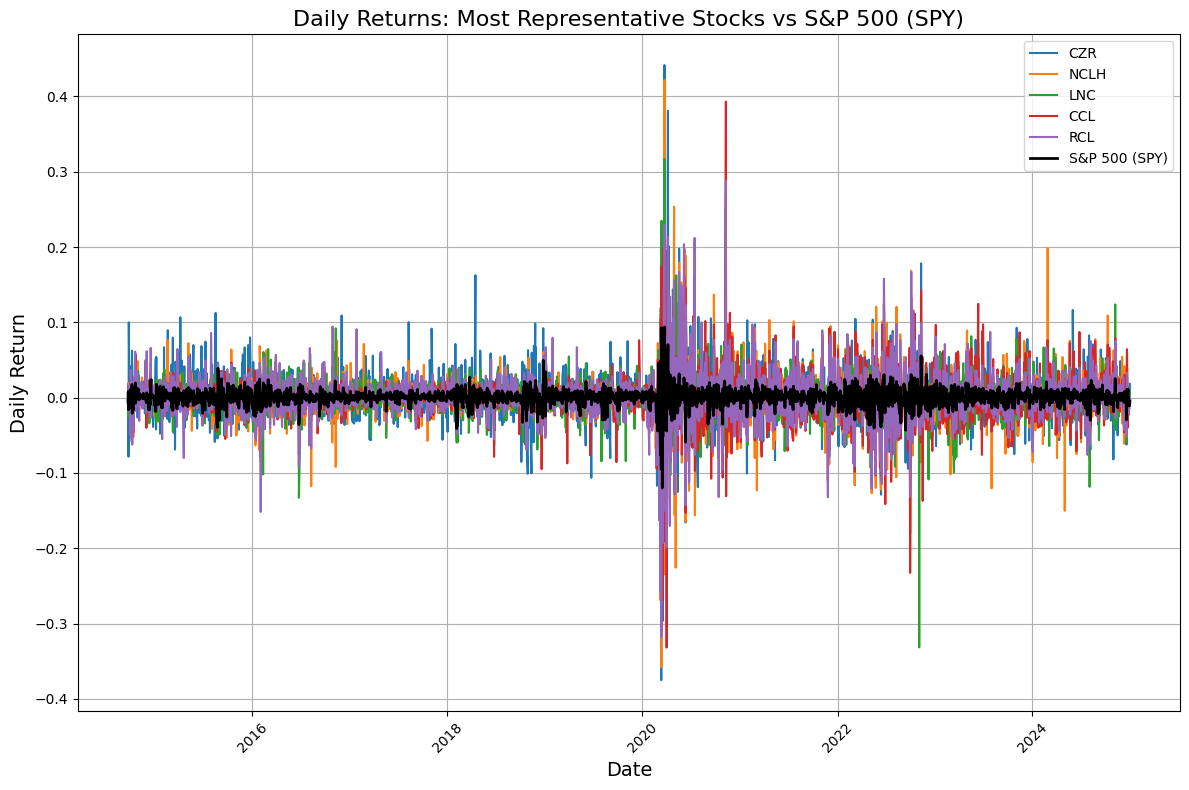

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr

# Define the start and end date for the data fetching
start_date = '2010-01-01'
end_date = '2025-01-01'

# Define your DataFrame df (assuming it is already populated with stock data)
# Here, we directly fetch the data for top 5 most representative stocks based on PCA and SPY
top_stocks = ['CZR', 'NCLH', 'LNC', 'CCL', 'RCL']  # Based on PCA analysis

# Fetch SPY data (S&P 500 index)
try:
    spy = pdr.get_data_stooq("^SPX", start=start_date, end=end_date)["Close"]
except Exception as e:
    print(f"Failed to download SPY data from Stooq: {e}")
    raise

# Fetch data for the top representative stocks
top_stocks_data = {}
for ticker in top_stocks:
    try:
        stock_data = pdr.get_data_stooq(ticker, start=start_date, end=end_date)["Close"]
        top_stocks_data[ticker] = stock_data
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")
        raise

# Convert the dictionary to a DataFrame
top_stocks_df = pd.DataFrame(top_stocks_data)

# Add SPY data to the DataFrame
top_stocks_df['SPY'] = spy

# Compute daily returns for each stock and SPY
returns = top_stocks_df.pct_change().dropna()

# Plot the returns for the most representative stocks and SPY for comparison
plt.figure(figsize=(12, 8))

# Plot each stock's return
for ticker in top_stocks:
    plt.plot(returns.index, returns[ticker], label=ticker)

# Plot SPY returns for comparison
plt.plot(returns.index, returns['SPY'], label='S&P 500 (SPY)', color='black', linewidth=2)

# Add title and labels
plt.title('Daily Returns: Most Representative Stocks vs S&P 500 (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Return', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import time
import numpy as np
import pandas as pd
from typing import Union, Dict, Optional
from fastdtw import fastdtw
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
from joblib import Parallel, delayed  # For parallel distance computations


class TimeSeriesClustering:
    def __init__(self, df: pd.DataFrame, random_state: Optional[int] = 42):
        """
        Initialize clustering object with validation

        Args:
            df: DataFrame with rows as time series (tickers) and columns as timestamps
            random_state: Seed for reproducibility
        """
        self.random_state = random_state
        self.rng = check_random_state(random_state)
        
        # Validate and store data
        self._validate_data(df)
        self.raw_data = df.copy()
        self.processed_data = None
        self.distance_matrices = {}  # Cache for distance matrices

    def _validate_data(self, df: pd.DataFrame) -> None:
        """Comprehensive data validation"""
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
            
        if df.empty:
            raise ValueError("Input DataFrame is empty")
            
        if not df.apply(lambda s: pd.api.types.is_numeric_dtype(s)).all():
            raise ValueError("All DataFrame columns must be numeric")
            
        if df.isna().any().any():
            raise ValueError("Data contains missing values. Handle missing values first.")
            
        if np.isinf(df.values).any():
            raise ValueError("Data contains infinite values")

    def preprocess(self, method: str = 'pct_change', **kwargs) -> None:
        """
        Preprocess time series data with proper look-forward protection
        
        Args:
            method: Preprocessing method ('pct_change' or 'standardize')
            kwargs: Additional arguments for preprocessing
        """
        if method == 'pct_change':
            # Compute percentage change across time (axis=1)
            processed = self.raw_data.pct_change(axis=1, **kwargs)
            
            # Handle NaNs by forward filling (no look-ahead bias)
            processed = processed.ffill(axis=1).bfill(axis=1)  # Handle initial NaN
            
        elif method == 'standardize':
            # Z-score standardization per time series
            means = self.raw_data.mean(axis=1)
            stds = self.raw_data.std(axis=1)
            processed = (self.raw_data.sub(means, axis=0)).div(stds, axis=0)
            
        elif method == 'returns_standardize':
            # First compute returns
            returns = self.raw_data.pct_change(axis=1, **kwargs)
            # Then standardize the returns
            means = returns.mean(axis=1)
            stds = returns.std(axis=1)
            processed = (returns.sub(means, axis=0)).div(stds, axis=0)
            processed = processed.ffill(axis=1).bfill(axis=1)
            
        else:
            raise ValueError(f"Unknown preprocessing method: {method}")
        
        self.processed_data = processed.dropna(axis=1)  # Remove columns with remaining NaNs

    def _compute_distance_matrix(self, metric: str = 'euclidean', **dtw_args) -> np.ndarray:
        """
        Compute distance matrix with caching and parallel processing
        
        Args:
            metric: Distance metric ('euclidean' or 'fastdtw')
            dtw_args: Additional arguments for FastDTW
        """
        if metric not in ['euclidean', 'fastdtw']:
            raise ValueError(f"Unsupported distance metric: {metric}")

        # Check cache first
        cache_key = f"{metric}_{hash(frozenset(dtw_args.items()))}"
        if cache_key in self.distance_matrices:
            return self.distance_matrices[cache_key]

        data = self.processed_data.values
        
        if metric == 'euclidean':
            distances = pdist(data, metric='euclidean')
        else:
            # Parallel FastDTW computation
            n_samples = data.shape[0]
            indices = np.triu_indices(n_samples, k=1)
            
            def _parallel_dtw(i, j):
                return fastdtw(data[i], data[j], **dtw_args)[0]

            results = Parallel(n_jobs=-1)(
                delayed(_parallel_dtw)(i, j) 
                for i, j in zip(indices[0], indices[1])
            )
            
            distances = np.array(results)

        # Cache and return squareform matrix
        self.distance_matrices[cache_key] = squareform(distances)
        return self.distance_matrices[cache_key]

    def hierarchical_clustering(
        self,
        n_clusters: int,
        metric: str = 'euclidean',
        linkage_method: str = 'ward',
        **dtw_args
    ) -> Dict:
        """Hierarchical clustering with automatic method selection"""
        if metric == 'fastdtw' and linkage_method == 'ward':
            raise ValueError("Ward linkage can't be used with non-Euclidean distances")

        distance_matrix = self._compute_distance_matrix(metric, **dtw_args)
        Z = linkage(distance_matrix, method=linkage_method)
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        
        # Silhouette score calculation
        sil_score = self._calculate_silhouette(clusters, distance_matrix, metric)
        
        return {
            'linkage_matrix': Z,
            'clusters': clusters,
            'silhouette_score': sil_score,
            'n_clusters': len(np.unique(clusters))
        }

    def kmeans_clustering(
        self,
        n_clusters: int,
        init: str = 'k-means++',
        n_init: int = 10,
        **kwargs
    ) -> Dict:
        """KMeans clustering with proper initialization"""
        model = KMeans(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init,
            random_state=self.random_state,
            **kwargs
        )
        
        clusters = model.fit_predict(self.processed_data.values)
        
        return {
            'clusters': clusters,
            'silhouette_score': silhouette_score(
                self.processed_data.values, 
                clusters,
                metric='euclidean'
            ),
            'inertia': model.inertia_,
            'n_clusters': n_clusters
        }

    def dbscan_clustering(
        self,
        eps: float,
        min_samples: int = 5,
        metric: str = 'euclidean',
        **dtw_args
    ) -> Dict:
        """DBSCAN clustering with proper distance matrix handling"""
        distance_matrix = self._compute_distance_matrix(metric, **dtw_args)
        model = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='precomputed',
            n_jobs=-1
        )
        
        clusters = model.fit_predict(distance_matrix)
        n_clusters = len(np.unique(clusters)) - (1 if -1 in clusters else 0)
        
        return {
            'clusters': clusters,
            'silhouette_score': self._calculate_silhouette(clusters, distance_matrix, metric),
            'n_clusters': n_clusters,
            'core_sample_indices': model.core_sample_indices_
        }

    def _calculate_silhouette(
        self,
        clusters: np.ndarray,
        distance_matrix: np.ndarray,
        metric: str
    ) -> float:
        """Safe silhouette score calculation"""
        unique_clusters = np.unique(clusters)
        if len(unique_clusters) < 2:
            return np.nan
        
        # Handle noise points in DBSCAN
        mask = clusters != -1 if -1 in clusters else slice(None)
        
        if metric == 'euclidean':
            return silhouette_score(
                self.processed_data.values[mask],
                clusters[mask],
                metric='euclidean'
            )
        else:
            return silhouette_score(
                distance_matrix[mask][:, mask],
                clusters[mask],
                metric='precomputed'
            )

    def plot_elbow(self, max_clusters: int = 15) -> None:
        """Improved elbow method with automatic knee detection"""
        inertias = []
        for k in range(1, max_clusters + 1):
            model = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                n_init='auto'
            ).fit(self.processed_data.values)
            inertias.append(model.inertia_)

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_clusters + 1), inertias, 'bo-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.grid(True)
        plt.show()

    def plot_dendrogram(
        self,
        linkage_matrix: np.ndarray,
        title: str = "Hierarchical Clustering Dendrogram",
        **kwargs
    ) -> None:
        """Enhanced dendrogram visualization"""
        plt.figure(figsize=(15, 8))
        dendrogram(
            linkage_matrix,
            labels=self.processed_data.index.tolist(),
            orientation='top',
            **kwargs
        )
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def analyze_clusters(self, clusters: np.ndarray) -> pd.DataFrame:
        """Comprehensive cluster analysis"""
        analysis = []
        for cluster_id in np.unique(clusters):
            mask = clusters == cluster_id
            cluster_data = self.raw_data[mask]
            
            stats = {
                'cluster': cluster_id,
                'size': cluster_data.shape[0],
                'mean_return': cluster_data.pct_change(axis=1).mean().mean(),
                'volatility': cluster_data.pct_change(axis=1).std().mean(),
                'total_return': (cluster_data.iloc[:, -1] / cluster_data.iloc[:, 0] - 1).mean()
            }
            
            analysis.append(stats)
            
        return pd.DataFrame(analysis).set_index('cluster')


In [ ]:
# Initialize the DTWClustering with the sliced DataFrame
clustering = TimeSeriesClustering(df_sp500).preprocess()



In [ ]:
#elbow method for kmeans clustering
clustering.plot_elbow()

AttributeError: 'NoneType' object has no attribute 'plot_elbow'

In [ ]:
# Hierarchical Clustering with FastDTW Distance
print("\nHierarchical Clustering with FastDTW Distance:")
hierarchical_results_fastdtw = dtw_clustering.hierarchical_clustering(k=4, distance_metric="fastdtw")

print(hierarchical_results_fastdtw)

In [ ]:
hierarchical_cluster_fastDTW=hierarchical_results_fastdtw["clusters"] -1
hierarchical_cluster_fastDTW

In [ ]:
# Hierarchical Clustering with Euclidean Distance
print("\nHierarchical Clustering with Euclidean Distance:")
hierarchical_results_euclidean = dtw_clustering.hierarchical_clustering(k=4, distance_metric="euclidean")

print(hierarchical_results_euclidean)

In [ ]:
hierarchical_cluster_euclidean=hierarchical_results_euclidean["clusters"] -1
hierarchical_cluster_euclidean

In [ ]:
# KMeans Clustering with Euclidean Distance
print("\nKMeans Clustering with Euclidean Distance:")
kmeans_results_euclidean = dtw_clustering.kmeans_clustering(k=4, distance_metric="euclidean")
print(kmeans_results_euclidean)

In [ ]:
kmeans_cluster_euclidean=kmeans_results_euclidean["clusters"]
kmeans_cluster_euclidean

In [ ]:
dtw_clustering_transposed_actual_values=dtw_clustering.df_actual.T
dtw_clustering_transposed_actual_values

In [ ]:
dtw_clustering_transposed_actual_values['Hierarchical_Cluster_euclidean'] = hierarchical_cluster_euclidean
#dtw_clustering_transposed_actual_values['Hierarchical_Cluster_DTW'] = hierarchical_cluster_fastDTW
dtw_clustering_transposed_actual_values['KMeans_Cluster'] = kmeans_cluster_euclidean

In [ ]:
dtw_clustering_transposed_actual_values

In [ ]:
dtw_clustering_transposed_pct_change=dtw_clustering.df_pct_change.T
dtw_clustering_transposed_pct_change

In [ ]:
dtw_clustering_transposed_pct_change['Hierarchical_Cluster_euclidean'] = hierarchical_cluster_euclidean
#dtw_clustering_transposed_pct_change['Hierarchical_Cluster_DTW'] = hierarchical_cluster_fastDTW
dtw_clustering_transposed_pct_change['KMeans_Cluster'] = kmeans_cluster_euclidean

In [ ]:
dtw_clustering_transposed_pct_change

In [ ]:
# Plot dendrograms
print("\nPlotting Dendrogram for Euclidean Hierarchical Clustering:")
dtw_clustering.plot_dendrogram(hierarchical_results_euclidean["linkage_matrix"], title="Euclidean Distance Dendrogram")

print("\nPlotting Dendrogram for FastDTW Hierarchical Clustering:")
#dtw_clustering.plot_dendrogram(hierarchical_results_fastdtw["linkage_matrix"], title="FastDTW Distance Dendrogram")

# Analyze clusters for both hierarchical methods
print("\nCluster Analysis for Euclidean Hierarchical Clustering:")
dtw_clustering.analyze_clusters(hierarchical_results_euclidean, k=2, title_prefix="Euclidean Hierarchical")

print("\nCluster Analysis for FastDTW Hierarchical Clustering:")
dtw_clustering.analyze_clusters(hierarchical_results_fastdtw, k=2, title_prefix="FastDTW Hierarchical")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cluster_timeseries(df_actual, df_pct, clustering_columns):
    """
    Plots the time series of tickers in each cluster for both actual values and pct change values.
    
    Args:
    - df_actual (pd.DataFrame): Dataframe containing actual values with tickers as rows and timestamps as columns.
    - df_pct (pd.DataFrame): Dataframe containing percentage change values with tickers as rows and timestamps as columns.
    - clustering_columns (list): List of column names corresponding to the clustering algorithms.
    
    Returns:
    - None
    """
    
    # Iterate over each clustering type (one column for each clustering algorithm)
    for clustering_col in clustering_columns:
        # Get unique clusters
        clusters = df_actual[clustering_col].unique()
        num_clusters = len(clusters)

        # Set number of rows and columns: 2 rows per cluster (one for actual, one for pct change)
        nrows = num_clusters  # One row per cluster
        ncols = 2  # Two columns (one for actual, one for pct change)

        # Create figure with appropriate size
        plt.figure(figsize=(18, 5 * num_clusters))  # Adjust the size for multiple rows

        plt.suptitle(f"Cluster Timeseries for {clustering_col}", fontsize=16)

        # Plot actual values for each cluster (first column)
        for idx, cluster in enumerate(clusters):
            tickers_in_cluster = df_actual[df_actual[clustering_col] == cluster].index
            df_cluster_actual = df_actual.loc[tickers_in_cluster].drop(columns=[clustering_col])

            if not df_cluster_actual.empty:
                ax = plt.subplot(nrows, ncols, idx * 2 + 1)  # First column for actual values
                df_cluster_actual.transpose().plot(title=f"Cluster {cluster} - Actual", ax=ax, legend = False)
                ax.set_xlabel('')  # Hide x-axis label
                ax.set_ylabel('')  # Hide y-axis label
                ax.set_xticks([])  # Remove x-axis ticks (no tick marks)
                ax.set_xticklabels([])  # Remove x-axis labels (no tick labels)
        
        # Plot pct change values for each cluster (second column)
        for idx, cluster in enumerate(clusters):
            tickers_in_cluster = df_pct[df_pct[clustering_col] == cluster].index
            df_cluster_pct = df_pct.loc[tickers_in_cluster].drop(columns=[clustering_col])

            if not df_cluster_pct.empty:
                ax = plt.subplot(nrows, ncols, idx * 2 + 2)  # Second column for pct change
                df_cluster_pct.transpose().plot(title=f"Cluster {cluster} - % Change", ax=ax, legend = False)
                ax.set_xlabel('')  # Hide x-axis label
                ax.set_ylabel('')  # Hide y-axis label
                ax.set_xticks([])  # Remove x-axis ticks (no tick marks)
                ax.set_xticklabels([])  # Remove x-axis labels (no tick labels)
        
        # Adjust layout to be more spacious
        plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])  # Increase the pad for more space
        plt.show()



In [ ]:
# Example usage:
# Assuming `df_actual` and `df_pct` are your dataframes containing the actual values and percentage change values, respectively.
# Also assuming the clustering columns are named 'clustering_type_1', 'clustering_type_2', and 'clustering_type_3'.
clustering_columns = ['Hierarchical_Cluster_euclidean', 'KMeans_Cluster']
plot_cluster_timeseries(dtw_clustering_transposed_actual_values, dtw_clustering_transposed_pct_change, clustering_columns)

